# Dog Leg optimization

## Process

    - Take the starting coordinates of WF6 and WF7
    - Generate Dog Leg path
    - Run Dog Legs
    - Output data for Gradient Descent function
    - Determine new starting coordinates of WF6 and WF7
    - Repeat

#### Imports

In [1]:
import Master as M
import time
import matplotlib.pyplot as plt
import numpy as np
from datetime import datetime
import Tag_Database as Tags
from plot_functions import plot_traj, plot_scatter, linear_fit
from read_dogleg import read_dogleg, gen_perturb_scan
start_time = time.time() #Grabbing the time at start to time process

#### Establish connection to PLC

In [32]:
Client = M.Make_Client('10.50.0.10')

Pulsing_Status = bool(M.Read(Client, Tags.Pulsing_Output, Bool = True)) #Detects whether pulsing or not

if Pulsing_Status:
    count = 25 #Integer. How many points will be recorded at each step and averaged over if pulsing
    sleep_time = 0.010 #Float.(ms)Sleep for 20 ms, this is tested to not overload PLC or give redundant data
else:
    count = 10 #Non-pulsing count of steps to take
    sleep_time = 0.010 #Non-pulsing sleep time

#### Establish Tag List for Data collection

In [33]:
Tag_List = [[Tags.WF6H, False], [Tags.WF7H, False], [Tags.WF6V, False], [Tags.WF7V, False], \
            [Tags.Emitted_Current, True], [Tags.Recirculator_Halfway, True], \
            [Tags.Recirculator_Bypass, True], [Tags.CU_V, False], [Tags.SRF_Pt, False]]

WF6H_Start = M.Read(Client, Tags.WF6H)
WF7H_Start = M.Read(Client, Tags.WF7H)
WF6V_Start = M.Read(Client, Tags.WF6V)
WF7V_Start = M.Read(Client, Tags.WF7V)

## Creating dog leg data sets

In [35]:
Perturbation_Step = 0.025 #Amps, once upward and once downward

WF6H_Dog_Legs = [WF6H_Start, WF6H_Start, WF6H_Start + Perturbation_Step]
WF7H_Dog_Legs = [WF7H_Start, WF7H_Start, WF7H_Start]
WF6V_Dog_Legs = [WF6V_Start, WF6V_Start + Perturbation_Step, WF6V_Start]
WF7V_Dog_Legs = [WF7V_Start, WF7V_Start, WF7V_Start]

In [37]:
for iteration in range(len(WF6H_Dog_Legs)):
    M.Dog_Leg(Client, Tags.WF6H, Tags.WF6V, Tags.WF7H, Tags.WF7V, \
              Tags.Recirculator_Halfway, Tags.Recirculator_Bypass, \
              Tag_List, \
              WF6H_Dog_Legs[iteration], WF6V_Dog_Legs[iteration], \
              WF7H_Dog_Legs[iteration], WF7V_Dog_Legs[iteration], \
              count = count, sleep_time = sleep_time, \
              Theshold_Percent = 0\)

-0.016503170132637024 0.010000000707805157 -0.16931875050067902 0.020000001415610313
-0.016503170132637024 0.010000000707805157 -0.14431875050067902 0.020000001415610313
0.008496829867362977 0.010000000707805157 -0.16931875050067902 0.020000001415610313


In [267]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn
import time
seaborn.set()
from mpl_toolkits import mplot3d
import matplotlib as mpl

def function(x_cord, y_cord, a = 1, b = 100):
    #return -1 * ((a - x_cord)**2 + b*(y_cord - x_cord**2)**2) #rosenbrock function
    return -1* ((0.5 * x_cord**2) - (4 * x_cord) + (0.2 * y_cord**2) + (2.7 * y_cord) + 17.8) #Chase's function

def centroid(vertex1, vertex2, vertex3):
    '''Vertices in the format:
    vertex1 = [X,Y]
    vertex2 = [X,Y]
    vertex3 = [X,Y]
    '''
    Ox = (vertex1[0] + vertex2[0] + vertex3[0])/3
    Oy = (vertex1[1] + vertex2[1] + vertex3[1])/3
    plt.scatter(Ox, Oy, color = 'black', label = 'centroid')
    return np.array([Ox, Oy])


def reflection_coordinate(worst_vertex, centroid, alpha = 1):
    '''blah
    
    '''    
    Xr = centroid + alpha*(centroid - worst_vertex)
    plt.scatter(Xr[0], Xr[1], color = 'blue', label = 'reflected coordinate', alpha = 0.25)
    return Xr

def expansion_coordinate(reflected_coordinate, centroid, gamma = 2):
    Xe = centroid + gamma*(reflected_coordinate - centroid)
    plt.scatter(Xe[0], Xe[1], color = 'gray', label = 'expansion coordinate', alpha = 0.25)
    return Xe

def contraction_coordinate(worst_vertex, centroid, rho = 0.5):
    Xc = centroid + rho*(worst_vertex - centroid)
    plt.scatter(Xc[0], Xc[1], color = 'firebrick', label = 'contraction coordinate', alpha = 0.25)
    return Xc

def simplex_optimization_step(dog_legs, enum, alpha = 1, gamma = 2, rho = 0.5):
    """Dog Legs in the format:
        [[WFH, WFV, FOM],
         [WFH, WFV, FOM],
         [WFH, WFV, FOM]]
    
    """
    
    v1 = dog_legs[0]
    v2 = dog_legs[1]
    v3 = dog_legs[2]
    
    plt.scatter(dog_legs[:,0], dog_legs[:,1], color = 'red')
    
    Xo = centroid(v1[:2], v2[:2], v3[:2])
    
    worst_index = np.where(dog_legs[:,2] == min(dog_legs[:,2]))[0][0]
    best_index = np.where(dog_legs[:,2] == max(dog_legs[:,2]))[0][0]
    middle_index = np.where([i not in [best_index,worst_index] for i in [0,1,2]])[0][0] #Getting the index not used in [0,1,2]
    #print(worst_index, middle_index, best_index)
    Xr = reflection_coordinate(dog_legs[worst_index,:2], Xo, alpha)
    #Xe = expansion_coordinate(Xr, Xo)
    #Xc = contraction_coordinate(dog_legs[worst_index,:2], Xo)
    
    #print(Xr, Xe, Xc)
    
    ##############
    #Ramp_Two to Xr, perform a dog leg
    #perform dog leg at Xr, get the figure of merit and compare in the following way
    ##############
    enum += 1
    reflected_FOM = function(Xr[0], Xr[1]) #fake dog leg results
    

    if reflected_FOM > dog_legs[middle_index,2] and reflected_FOM <= dog_legs[best_index,2]:
        #replace worst coordinates with Xr and end of simplex step
        #print('reflection step')
        reflected_coords = list(Xr)
        reflected_coords.append(reflected_FOM)
        dog_legs[worst_index] = np.array(reflected_coords)
        return dog_legs, enum
    
    if reflected_FOM > dog_legs[best_index,2]:
        # Run a dog leg at Xe
        #Ramp_Two
        #print('expansion step')
        Xe = expansion_coordinate(Xr, Xo, gamma)
        enum += 1
        expansion_FOM = function(Xe[0], Xe[1])
        if expansion_FOM > reflected_FOM:
            expansion_coords = list(Xe)
            expansion_coords.append(expansion_FOM)
            dog_legs[worst_index] = np.array(expansion_coords)
            return dog_legs, enum
        else:
            reflected_coords = list(Xr)
            reflected_coords.append(reflected_FOM)
            dog_legs[worst_index] = np.array(reflected_coords)
            return dog_legs, enum
            
    
    if reflected_FOM <= dog_legs[middle_index,2]:
        # Run a dog leg at Xc
        #Ramp_Two
        #print('contraction step')
        Xc = contraction_coordinate(dog_legs[worst_index,:2], Xo, rho)
        enum += 1
        contraction_FOM = function(Xc[0], Xc[1])
        if contraction_FOM >= dog_legs[worst_index,2]:
            contraction_coords = list(Xc)
            contraction_coords.append(contraction_FOM)
            dog_legs[worst_index] = np.array(contraction_coords)
            return dog_legs, enum
        else:
            #print("Your function is too far from the maximum please choose a new set of starting points")
            contraction_coords = list(Xc)
            contraction_coords.append(contraction_FOM)
            dog_legs[worst_index] = np.array(contraction_coords)
            return dog_legs, enum
    else:
        print("You gotta be kidding me")
        print(reflected_FOM)

3.97979797979798 -6.737373737373737
[ 3.99547861 -6.80582046 -0.68813341] 33 Dog Legs to convergence


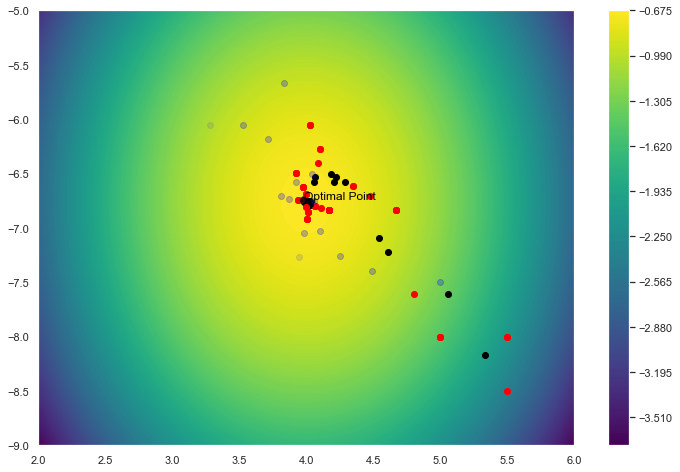

In [271]:
sample_data = [[5.5,-8],
              [5,-8],
              [5.5,-8.5]]

sample_data[0].append(function(sample_data[0][0], sample_data[0][1]))
sample_data[1].append(function(sample_data[1][0], sample_data[1][1]))
sample_data[2].append(function(sample_data[2][0], sample_data[2][1]))

sample_data = np.array(sample_data)

plt.figure(figsize = (12,8))


x = np.linspace(2, 6, 100)
y = np.linspace(-5,-9, 100)
X, Y = np.meshgrid(x, y)
#myfunc_vec = np.vectorize(function)
#function(xx,yy)
Z = function(X, Y)
coords = np.where(Z == np.max(Z))
print(x[coords[1][0]], y[coords[0][0]])
h = plt.contourf(X, Y, Z, 250, cmap = 'viridis')# extent = [-10,10,-10,10])
plt.colorbar()
plt.scatter(x[coords[1][0]], y[coords[0][0]], color = 'black')
plt.annotate(s = 'Optimal Point', xy = [x[coords[1][0]], y[coords[0][0]]], color = 'black')


gamma = 2
alpha = 2
rho = 0.5

tolerance = 0.0005

i = 0

new_simplex, i = simplex_optimization_step(sample_data, i, alpha = alpha, gamma = gamma, rho = rho)

for _ in range(250):
    new_simplex, i = simplex_optimization_step(new_simplex, i, alpha = alpha, gamma = gamma, rho = rho)

    #if np.isclose(new_simplex[0,0], new_simplex[1,0], atol = tolerance) and np.isclose(new_simplex[1,0], new_simplex[2,0], atol = tolerance):
    if np.allclose(new_simplex[:,2], new_simplex[0,2], atol = tolerance):
        break
    #print(new_simplex)
    #time.sleep(.001)
        #plt.draw()
best_index = np.where(new_simplex[:,2] == max(new_simplex[:,2]))[0][0]
#if np.isclose(new_simplex[0,0],x[coords[1][0]], atol = 0.005) and np.isclose(new_simplex[0,1],y[coords[0][0]], atol = 0.005): 
#if np.isclose(new_simplex[0,0],4, atol = tolerance) and np.isclose(new_simplex[0,1],-6.75, atol = tolerance): 
if np.allclose(new_simplex[:,2], new_simplex[0,2], atol = tolerance):
    print(new_simplex[best_index], "{} Dog Legs to convergence".format(i))
else:
    print("Converged at wrong point")
    print(new_simplex[best_index], i)
#plt.legend();
#plt.plot(new_simplex[:,0], new_simplex[:,1], alpha = 0.25, linewidth = 10)

In [251]:
b = 2
w = 0
m = np.where([i not in [b,w] for i in [0,1,2]])[0][0]
m

1

In [258]:
np.allclose(new_simplex[:,2], new_simplex[0,2], atol = tolerance)

True

In [2]:
import Dog_Leg_Master as M
import numpy as np
import matplotlib.pyplot as plt
from

In [9]:
Client.connect()

False